In [1]:
import os
import glob
import pandas as pd 
import numpy as np
import seaborn as sns
extension = 'csv'
all_filenames = ['quarterback_training.csv', 'quarterback_test.csv'] 
#combinando os arquivos cvs
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#exportar csv
combined_csv.to_csv( "quarterbackData.csv", index=False, encoding='utf-8-sig')
data = pd.read_csv('quarterbackData.csv')
data.drop(['DraftYear','Heisman'],axis = 1,inplace=True) #dropando colunas que sao irrelevantes no projeto
data

,Round,Pick,Age,GamesPlayed,Completions,Attempts,Yards,Touchdowns,Interceptions,RushAttempts,RushYards,RushTouchdowns,Player,College,Conference,Team,Verdict
0,1,16,23,43,600,897,7741,47,28,298,827,11,EJ Manuel,Florida St.,Atlantic Coast,BUF,0
1,2,39,22,44,988,1465,11662,98,21,245,342,4,Geno Smith,West Virginia,Big 12,NYJ,0
2,3,73,23,36,646,1069,7411,63,31,111,-281,3,Mike Glennon,North Carolina St.,Atlantic Coast,TAM,0
3,4,98,23,47,1001,1562,12327,116,48,132,-113,6,Matt Barkley,USC,Pac-12,PHI,0
4,4,110,23,47,791,1312,9190,70,28,242,168,5,Ryan Nassib,Syracuse,Atlantic Coast,NYG,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,6,178,23,30,407,659,5783,35,15,83,-313,0,Zach Mettenberger,LSU,Southeastern,TEN,0
143,1,1,21,37,606,1055,8872,67,23,631,3974,49,Lamar Jackson,Louisville,Atlantic Coast,CLE,1
144,1,2,21,30,711,1169,9301,59,26,109,-154,6,Josh Rosen,UCLA,Pac-12,NYG,1
145,1,9,21,26,523,801,6873,57,21,129,340,7,Sam Darnold,USC,Pac-12,CIN,1


In [2]:
import matplotlib.pyplot as plt

corr = data.corr()
corr.style.background_gradient(cmap='coolwarm') #tabela de correlacao

,Round,Pick,Age,GamesPlayed,Completions,Attempts,Yards,Touchdowns,Interceptions,RushAttempts,RushYards,RushTouchdowns,Verdict
Round,1.000000,0.989429,0.214269,-0.063742,-0.245640,-0.209419,-0.250641,-0.266463,-0.041335,-0.164485,-0.110784,-0.215569,-0.472794
Pick,0.989429,1.000000,0.196506,-0.067464,-0.249594,-0.220593,-0.259578,-0.278116,-0.030172,-0.166389,-0.114716,-0.217578,-0.464406
Age,0.214269,0.196506,1.000000,0.099885,0.023472,0.010321,0.012922,0.015743,0.050814,-0.123096,-0.150614,-0.181505,-0.289277
GamesPlayed,-0.063742,-0.067464,0.099885,1.000000,0.566399,0.660696,0.608379,0.548838,0.495500,0.383462,0.155098,0.237879,-0.041002
Completions,-0.245640,-0.249594,0.023472,0.566399,1.000000,0.904562,0.842364,0.830586,0.645719,0.058315,-0.196245,-0.021719,0.096577
Attempts,-0.209419,-0.220593,0.010321,0.660696,0.904562,1.000000,0.866614,0.812643,0.760709,0.180260,-0.123591,0.040615,0.043444
Yards,-0.250641,-0.259578,0.012922,0.608379,0.842364,0.866614,1.000000,0.834884,0.547826,0.159135,-0.078864,0.091726,0.063542
Touchdowns,-0.266463,-0.278116,0.015743,0.548838,0.830586,0.812643,0.834884,1.000000,0.475991,0.117356,-0.053413,0.072985,0.073724
Interceptions,-0.041335,-0.030172,0.050814,0.495500,0.645719,0.760709,0.547826,0.475991,1.000000,0.103543,-0.194023,-0.066070,-0.031312
RushAttempts,-0.164485,-0.166389,-0.123096,0.383462,0.058315,0.180260,0.159135,0.117356,0.103543,1.000000,0.876245,0.875311,0.028938


In [3]:
#DROPANDO COLUNAS COM ALTA CORRELACAO
# selecionando metade de cima do triangulo da matrix de correlacao
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Delentando colunas da metad superior que tem correlacao maior que 75%
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Dropando
data.drop(to_drop, axis=1, inplace=True)

data.isnull().sum()


Round           0
Age             0
GamesPlayed     0
Completions     0
RushAttempts    0
Player          0
College         0
Conference      0
Team            0
Verdict         0
dtype: int64

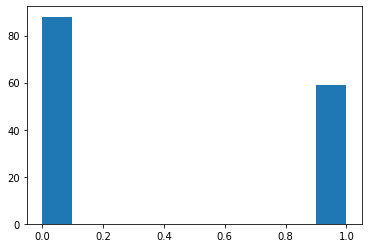

0    88
1    59
Name: Verdict, dtype: int64

In [4]:
plt.hist(data['Verdict'])
plt.show()
data.Verdict.value_counts()  #verificando balanceamento de classes

In [5]:
data.duplicated().sum()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for columns in data.columns:
     if data[columns].dtypes == 'object':
        data[columns] = le.fit_transform(data[columns])

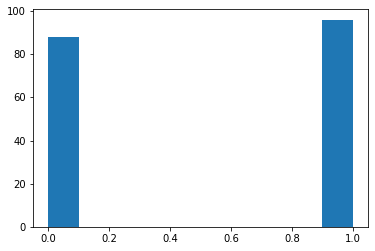

1    96
0    88
Name: Verdict, dtype: int64

In [6]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import SMOTE 
X = data[data.columns[:-1]].values
y = data['Verdict'].values
ada = ADASYN(random_state=67)
ros = RandomOverSampler(random_state=67)
ada.fit(X, y)
X_resampled, y_resampled = ada.fit_sample(X,y)
data = pd.DataFrame(data = X_resampled, columns = data.columns[:-1])

data['Verdict'] = y_resampled #fazendo oversampling para balancear melhor as classes

plt.hist(data['Verdict'])
plt.show()
data.Verdict.value_counts()

In [7]:
from sklearn import cluster, neighbors, svm, metrics, preprocessing 
from sklearn.metrics import confusion_matrix
trainSample = data.sample(frac=0.8, random_state = 1) #seleção de 80% da base para treinamento
testSample = pd.concat([data, trainSample]).drop_duplicates(keep=False)
trainTarget = trainSample["Verdict"] #define o atributo alvo da base para o treinamento
testTarget = testSample["Verdict"]
del testSample["Verdict"]
del trainSample["Verdict"]
rs = preprocessing.RobustScaler()
trainSample = rs.fit_transform(trainSample)
testSample = rs.fit_transform(testSample)
scores = {}
scores_list = []
k_range = range(1,101)
for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, algorithm="auto") #k vizinhos mais próximos = n_neighbors
    knn.fit(trainSample, trainTarget)
    resultKNN = knn.predict(testSample)
    scores[k] = metrics.accuracy_score(testTarget, resultKNN)
    scores_list.append(metrics.accuracy_score(testTarget, resultKNN))
    

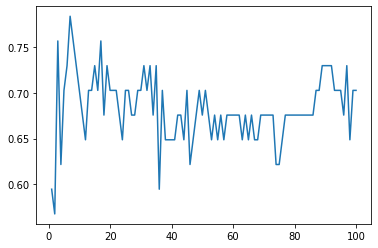

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range,scores_list)
#print(classification_report(y_true, y_pred))

In [9]:
from sklearn import linear_model,model_selection
from sklearn import preprocessing 
reg = linear_model.LinearRegression() #regressao linear
X = data.iloc[:,0:8]
y = data.iloc[:,9]               
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=101) #80/20
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)


MAE: 0.3840591154804546
MSE: 0.1991620298089851
RMSE: 0.44627573293759215


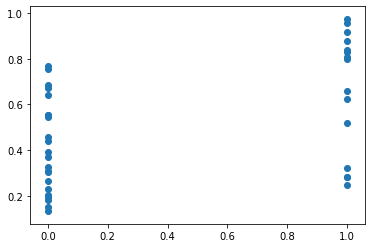

In [10]:
from sklearn import metrics
import seaborn as sns 
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
plt.scatter(y_test,y_pred)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
import time
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Pegando 20% do dataset para o teste.
test_dataset = data.sample(frac=0.2,random_state = 60)#setando o random state para garantir que esse conjunto de dadps seja replicavel

# Separando o data set de treinamento fazendo todo_dataset - test_dataset
train_dataset = data.drop(test_dataset.index)

y_train = train_dataset["Verdict"]
x_train = train_dataset.drop(columns=["Verdict"])
y_test = test_dataset["Verdict"]
x_test = test_dataset.drop(columns=["Verdict"])



param_grid = { 'max_features': ['sqrt', 'log2'],
               'criterion': ['gini', 'entropy'],
               'max_depth': [5, 10, 15, 20]}
    
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring="accuracy", return_train_score=False)
    
clf.fit(x_train, y_train)
print("Best parameters combination: %s\n" % clf.best_params_)

# prevendo usando o modelo preparado
y_true, y_pred = y_test, clf.best_estimator_.predict(x_test)
    
 # prevendo probabilidades de classes
predictions = clf.predict_proba(x_test)
    
# resultado

test_score = (clf.score(x_test, y_test)*100)
print("Test score: %s" % "{0:.3f}%\n".format(test_score))
    
cm=confusion_matrix(y_test, y_pred)
print('Matriz de Confusão:')
print(cm)

Best parameters combination: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt'}

Test score: 78.378%

Matriz de Confusão:
[[15  3]
 [ 5 14]]


In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2']) #resumindo todos os atributos em 2
principalDf

data = pd.concat([principalDf, data[['Verdict']]], axis = 1)
data

,principal component 1,principal component 2,Verdict
0,27.017393,61.520546,0
1,-358.376072,-8.154570,0
2,-9.971165,-128.049515,0
3,-365.830566,-122.479999,0
4,-160.708953,-3.783513,0
...,...,...,...
179,16.581377,73.029749,1
180,-216.651007,-96.143125,1
181,-420.686608,-106.222939,1
182,9.724952,389.268005,1


In [13]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
clustering = AgglomerativeClustering().fit(data)
AgglomerativeClustering(n_clusters=8, linkage = 'single')
clustering.labels_

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0])

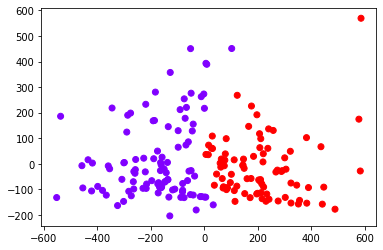

In [14]:
plt.scatter(data.iloc[:,0], data.iloc[:,1], c=clustering.labels_, cmap='rainbow') #mapa de clusters usando single linkage

In [15]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2,random_state=2).fit(data) # dois nucleos gerados aleatoriamente  
kmeans.labels_


array([2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 1, 1, 1, 0, 2, 0, 2, 2, 2, 0,
       1, 2, 0, 0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 1, 2,
       0, 2, 0, 1, 2, 1, 2, 0, 0, 1, 2, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 2,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       2, 0, 0, 2, 1, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 0, 2,
       2, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1,
       0, 1, 2, 2, 1, 1, 2, 1], dtype=int32)

In [16]:
kmeans.cluster_centers_


array([[ 222.34944002,  -33.3828986 ,    0.48684211],
       [-205.0569327 ,  -63.99971526,    0.51388889],
       [ -59.29050797,  198.47443869,    0.61111111]])

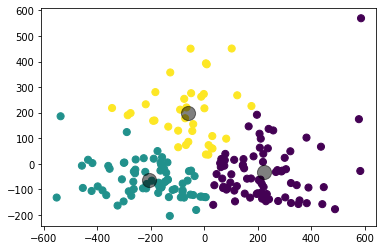

In [17]:
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=kmeans.predict(data), s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5); #grafico do k-means
